In [ ]:
!pip install numpy scipy matplotlib torchaudio librosa soundfile

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile
import IPython.display as ipd
import librosa, librosa.display
import os
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.signal import lfilter
from scipy import signal

## Data
- **Dataset Name**: `LibriSpeech`
- **Subset**: `test-clean`
- **Description**:  
  A clean and carefully segmented subset of LibriSpeech, intended for evaluation purposes.  
  It contains audio recordings of read English speech with minimal background noise.

In [10]:
# load data
data = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

100.0%


## LibriSpeech Dataset Item Format

Each entry in the **LibriSpeech** dataset is a tuple containing the following six elements:

1. **Tensor**
   - A tensor representing the audio waveform.
   - Shape: `(num_samples,)`
   - Data type: `torch.FloatTensor`

2. **Sampling Rate**
   - An integer specifying the sampling frequency of the audio.
   - Common value: `16000` Hz

3. **Transcript**
   - A string containing the text spoken in the audio clip.
   - Example: `"HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE"`

4. **Speaker ID**
   - A unique identifier for the speaker.
   - Format: `int`
   - Example: `1089`

5. **File ID**
   - An identifier for the specific audio file.
   - Format: `int`
   - Example: `134686`

6. **Utterance ID**
   - An identifier for the specific utterance within the file.
   - Format: `int`
   - Example: `0` (may be used to distinguish between multiple utterances in the same file)


In [24]:
sample = data[0]
s1 = sample[0]
s1 = s1.numpy()
sr1 = sample[1]

In [19]:
# data
print(len(data))
print(data[0])

2620
(tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]]), 16000, 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE', 1089, 134686, 0)


In [16]:
print(len(s1))
print(s1.shape)

1
(1, 166960)


## LibriSpeech Audio Processing

In our analysis, the LibriSpeech dataset is primarily utilized through libraries such as:

- **IPython**: For interactive audio playback during analysis or debugging.
- **Librosa**: For audio preprocessing and feature extraction.

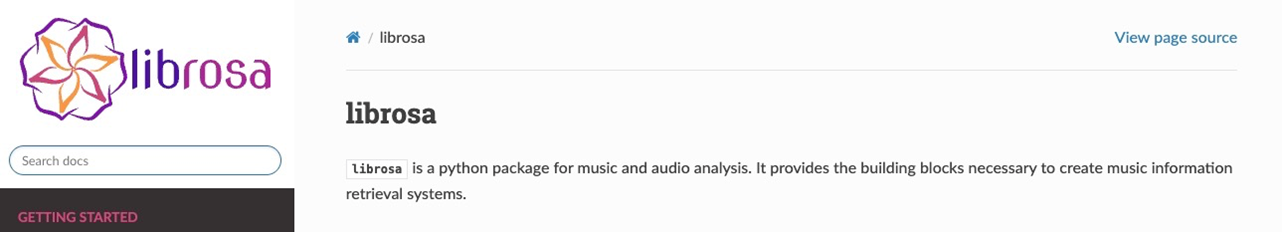

In our practical environment, we actively utilize the Librosa library. 

You can learn about the various functions and detailed aspects provided by Librosa by referring to the official documentation available at the link below.

https://librosa.org/doc/latest/index.html


## Typical Code Usage

The following code demonstrates a common sequence used in practical sessions:

1. **Audio Preparation**
   - Reshape the audio waveform to remove extra dimensions.
   - Normalize the waveform for consistent amplitude scaling.

2. **Audio Playback**
   - Extract a specific segment of the audio.
   - Play the selected portion using IPython.

In [44]:
s1 = s1.squeeze() #(1,166960) -> (166960,)
s1 = librosa.util.normalize(s1)

print("Duration (seconds):", len(s1) / sr1)

ipd.Audio(s1, rate=sr1)

Duration (seconds): 10.435


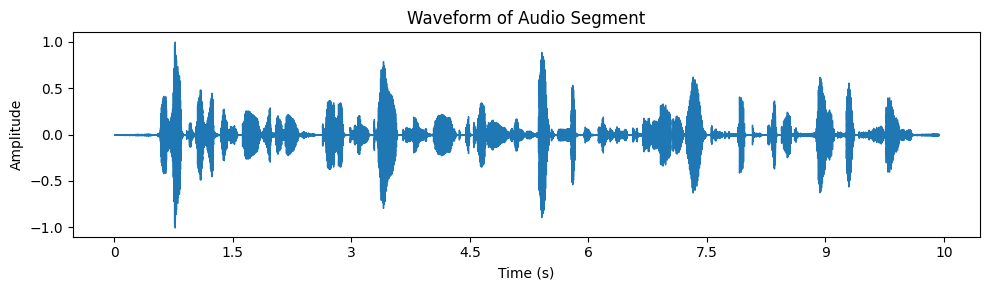

In [45]:
plt.figure(figsize=(10, 3))
librosa.display.waveshow(s1, sr=sr1)
plt.title("Waveform of Audio Segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

## Spectrogram Generation
### Description

- **`n_fft = 1024`**
  - The number of samples used for each FFT (Fast Fourier Transform) window.
  - A larger `n_fft` gives **better frequency resolution** but worse time resolution.
  - Common values: 512, 1024, 2048

- **`hop_length = 256`**
  - The number of samples between successive frames.
  - Controls **time resolution**: smaller values give more overlap between frames and better time detail.
  - Rule of thumb: `hop_length ≈ n_fft // 4` (25% overlap)

In [46]:
waveform, sample_rate, _, _, _, _ = data[0]
waveform = waveform.squeeze()

waveform_np = waveform.numpy()

n_fft=1024
hop_length=256

# Calculate duration of hop and window (in seconds)
hop_length_duration = float(hop_length) / sample_rate
n_fft_duration = float(n_fft) / sample_rate

print("STFT hop length duration (seconds):", hop_length_duration)
print("STFT window duration (seconds):", n_fft_duration)

STFT hop length duration (seconds): 0.016
STFT window duration (seconds): 0.064


In [ ]:
stft = librosa.stft(waveform_np, n_fft=n_fft, hop_length=hop_length)
# Convert the complex STFT result into its magnitude
spectrogram = np.abs(stft) 
print(stft)
print(spectrogram) # phase removed


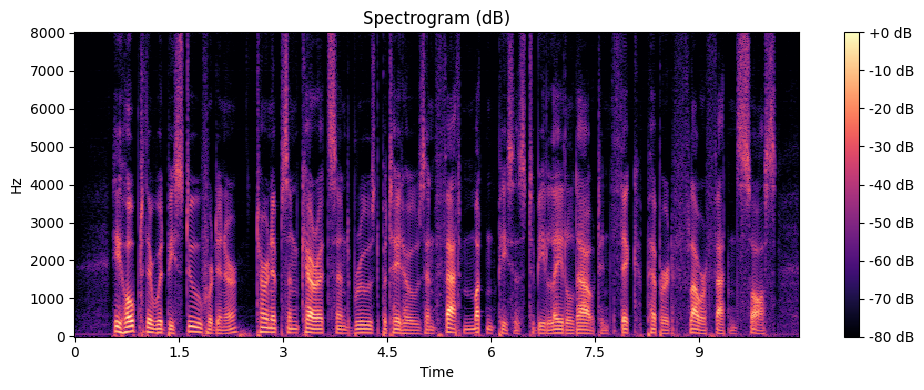

In [59]:
plt.figure(figsize=(10, 4))

# Convert linear magnitude to decibel (dB) scale and store it
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

# Display the dB spectrogram
librosa.display.specshow(
    spectrogram_db,
    sr=sample_rate,
    hop_length=hop_length,
    x_axis='time',
    y_axis='hz',
    cmap='magma'
)

plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.tight_layout()
plt.show()

## Speech Production

### Generate Impulse Train (=source at larynx)

Text(0.5, 0, 'time (msec)')

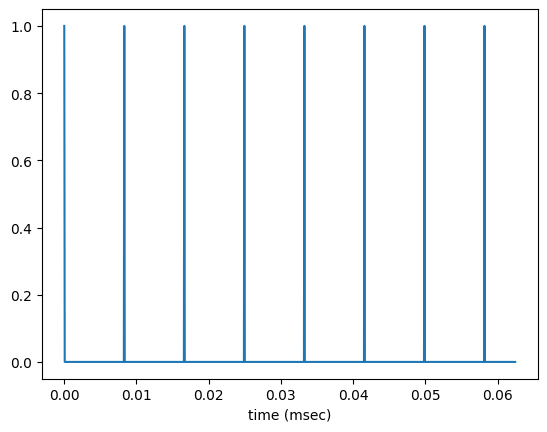

In [ ]:
sr = 16000   
duration = 1.0 # Duration of the signal in seconds
t = np.linspace(0, duration, int(sr * duration), endpoint=False) # A time vector representing equally spaced time steps from 0 to 1 second

# Glottal excitation (Impulse train)
f0 = 120  # Fundamental frequency in Hz
impulse_train = np.zeros_like(t)
period = int(sr / f0) # Number of samples between impulses
impulse_train[::period] = 1.0 # Insert an impulse (value of 1.0) every period samples 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], impulse_train[0:1000]);
ax.set_xlabel('time (msec)')

In [75]:
ipd.Audio(impulse_train, rate=sr)

### Formant-based Speech Signal Synthesis

The table below indicates that F1, F2, F3, F4, and F5 represent the characteristic formant frequencies for each vowel (/a/, /e/, /i/, /o/, /u/).

Let's generate a signal by referring to the table.

|       | /a/  | /e/  | /i/  | /o/  | /u/  | BW  |
|-------|------|------|------|------|------|-----|
| **F1** | 750  | 469  | 281  | 468  | 312  | 90  |
| **F2** | 1187 | 2031 | 2281 | 781  | 1219 | 110 |
| **F3** | 2595 | 2687 | 3187 | 2656 | 2469 | 170 |
| **F4** | 3781 | 3375 | 3781 | 3281 | 3406 | 250 |
| **F5** | 4200 | 4200 | 4200 | 4200 | 4200 | 300 |

Synthesizing and playing vowel: /a/


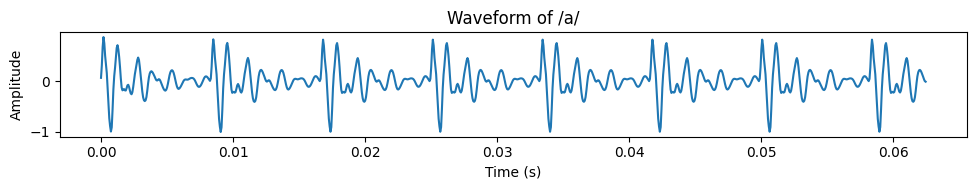

Synthesizing and playing vowel: /e/


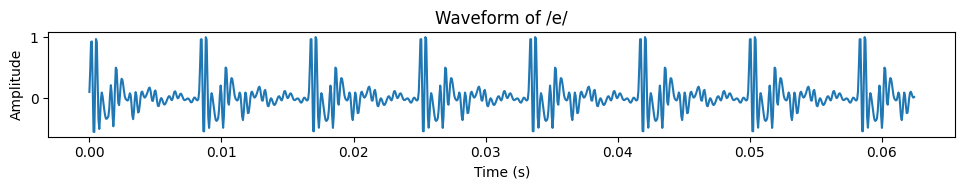

Synthesizing and playing vowel: /i/


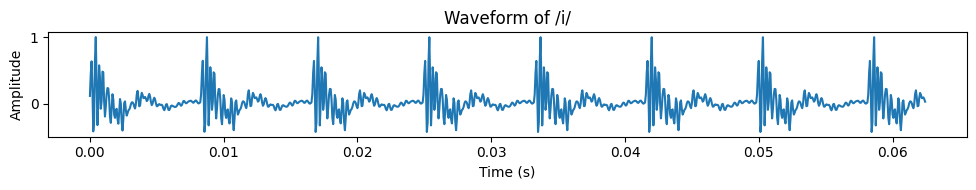

Synthesizing and playing vowel: /o/


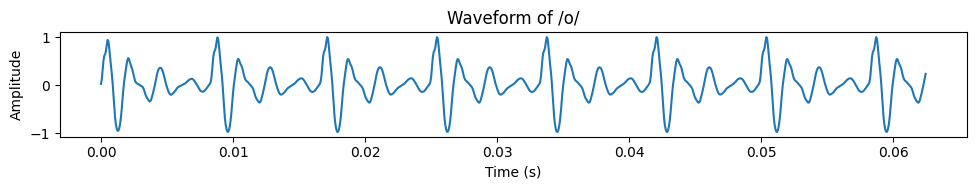

Synthesizing and playing vowel: /u/


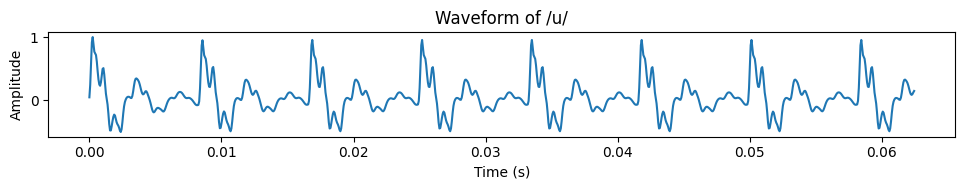

In [84]:
formant_table = {
    '/a/': [750, 1187, 2595, 3781, 4200],
    '/e/': [469, 2031, 2687, 3375, 4200],
    '/i/': [281, 2281, 3187, 3781, 4200],
    '/o/': [468, 781, 2656, 3281, 4200],
    '/u/': [312, 1219, 2469, 3406, 4200],
}
bandwidths = [90, 110, 170, 250, 300]  

# Formant filtering function (simulate the vocal tract)
def formant_filter(input_signal, formants, bws, sr):
    output = input_signal
    for f, bw in zip(formants, bws):
        r = np.exp(-np.pi * bw / sr) # r controls how long the resonance rings (higher r = longer ringing)
        theta = 2 * np.pi * f / sr # theta is the digital frequency (where the vocal tract resonates)
        a = [1, -2 * r * np.cos(theta), r ** 2]
        b = [1 - r]
        output = signal.lfilter(b, a, output)
    return output

# Synthesize and play each vowel
for vowel, formants in formant_table.items():
    print(f"Synthesizing and playing vowel: {vowel}")
    vowel_wave = formant_filter(impulse_train, formants, bandwidths, sr)
    vowel_wave = vowel_wave / np.max(np.abs(vowel_wave))  # normalize

    # Plot waveform
    plt.figure(figsize=(10, 2))
    plt.plot(t[:1000], vowel_wave[:1000])
    plt.title(f"Waveform of {vowel}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Play audio
    display(ipd.Audio(vowel_wave, rate=sr))